In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights
from src.utils_plot import plot_loss_and_all_solution, plot_transfer_learned_and_analytical
from src.load_save import load_run_history

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [11]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Thu Jan 11 15:49:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              N/A /   5W |    388MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
file_name = "DHO_10102021"
equation_name = "DHO"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
v_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=True)

In [31]:
# function to get A for alpha value and DHO equation
def get_A(alpha):
    return torch.tensor([[0., -1.], [1., 2*alpha]], device=dev).double()

# Numerical solution
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

r_tol = 1e-4
numerical_sol_fct_radau = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                  v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau", rtol=r_tol).y)

numerical_sol_fct_rk45 = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="RK45", rtol=r_tol).y)

numerical_sol_fct_lsoda = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="LSODA", rtol=r_tol).y)

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau, "LSODA": numerical_sol_fct_lsoda}

# True solution
def true_solution_Dho(alpha, y0, yp0, t):
    def gamma(alpha):
        return np.sqrt(alpha**2 - 1)

    def C2(y0, yp0, alpha):
        return (gamma(alpha) * y0 - alpha * y0 - yp0) / (2 * gamma(alpha))

    def C1(y0, yp0, alpha):
        return y0 - C2(y0, yp0, alpha)

    DAH_value = C1(y0, yp0, alpha) * np.exp(-(alpha - gamma(alpha)) * t) + \
                C2(y0, yp0, alpha) * np.exp(-(alpha + gamma(alpha)) * t)

    dDAH_value = -(alpha - gamma(alpha)) * C1(y0, yp0, alpha) * np.exp(-(alpha - gamma(alpha)) * t) + \
                 -(alpha + gamma(alpha)) * C2(y0, yp0, alpha) * np.exp(-(alpha + gamma(alpha)) * t)

    return np.array([DAH_value, dDAH_value]).squeeze()

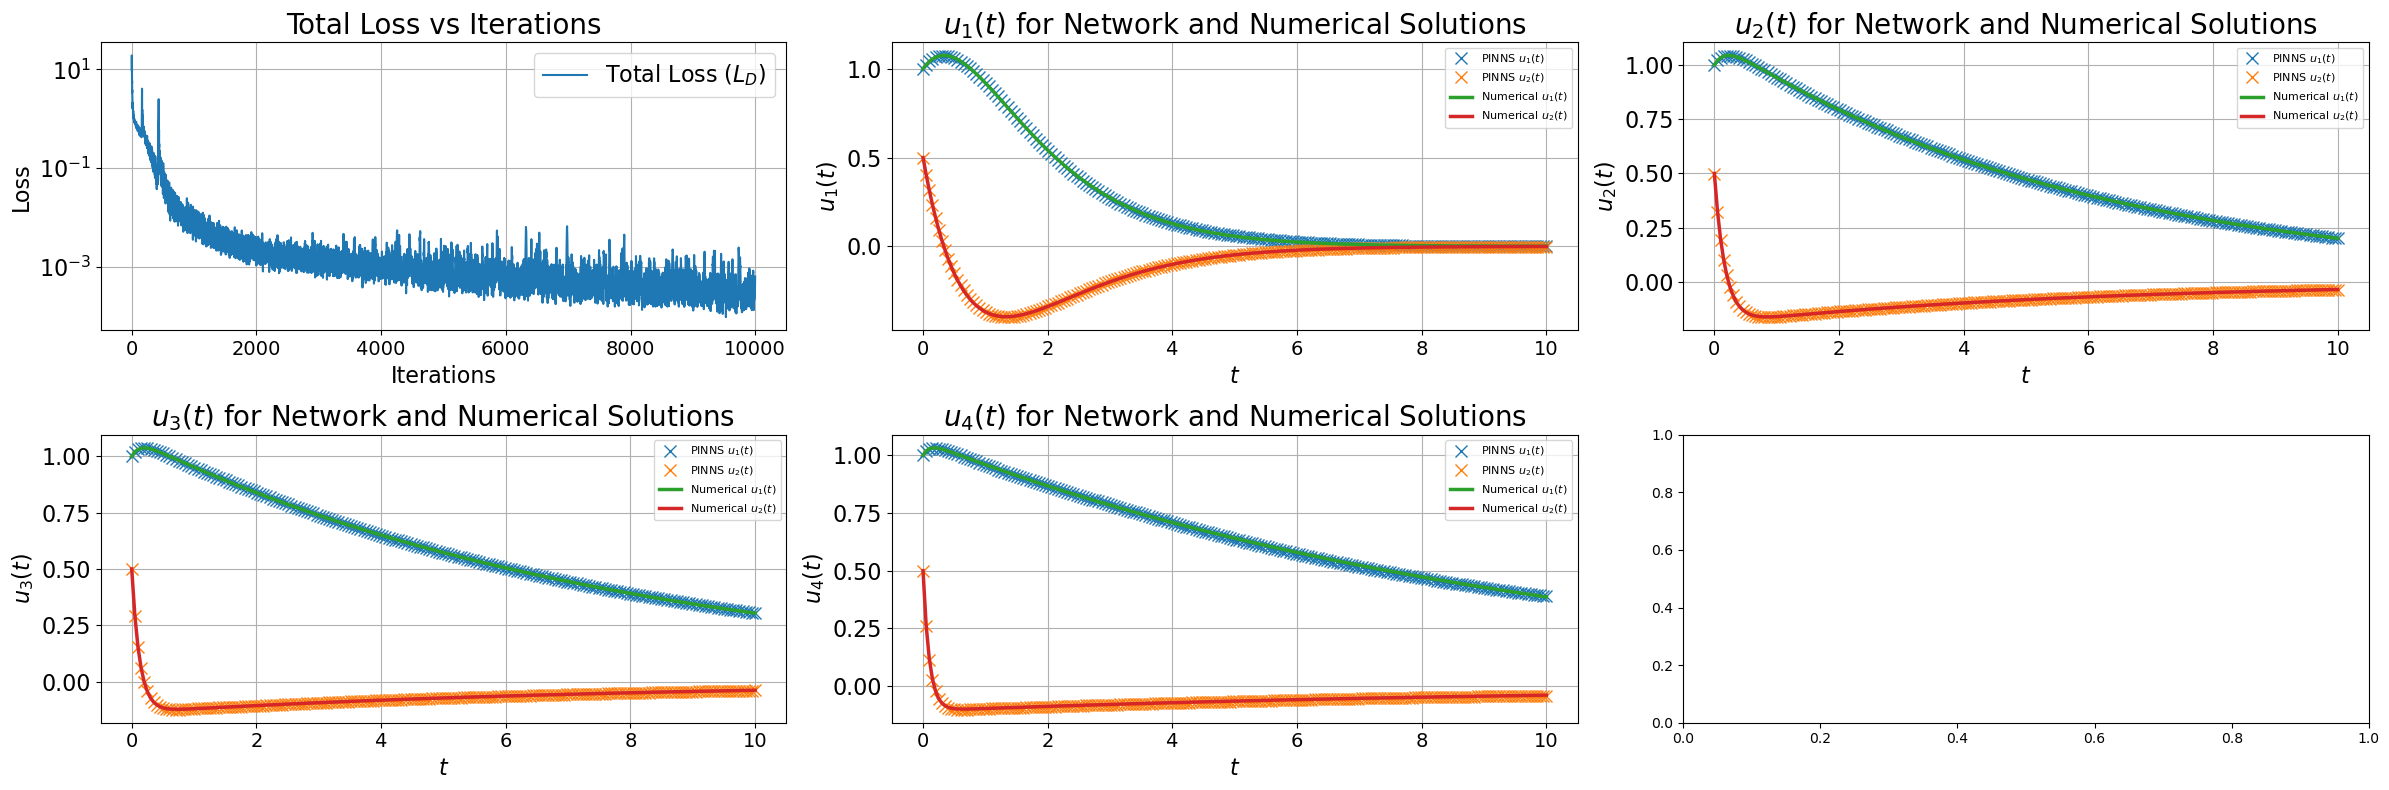

In [24]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct_radau,
                           trained_model=trained_model, v_list=v_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['Ltotal_losses'],
                           loss_label='Total Loss ($L_D$)', device=dev)

Time to compute H and dH_dt:  0.085 seconds
Time to compute weights (given H and dH_dt):  0.365 seconds
mean 5.628813720502364e-06
max 1.4402726964068968e-05
mean 1.8242806077471907e-06
max 6.651460035589363e-06


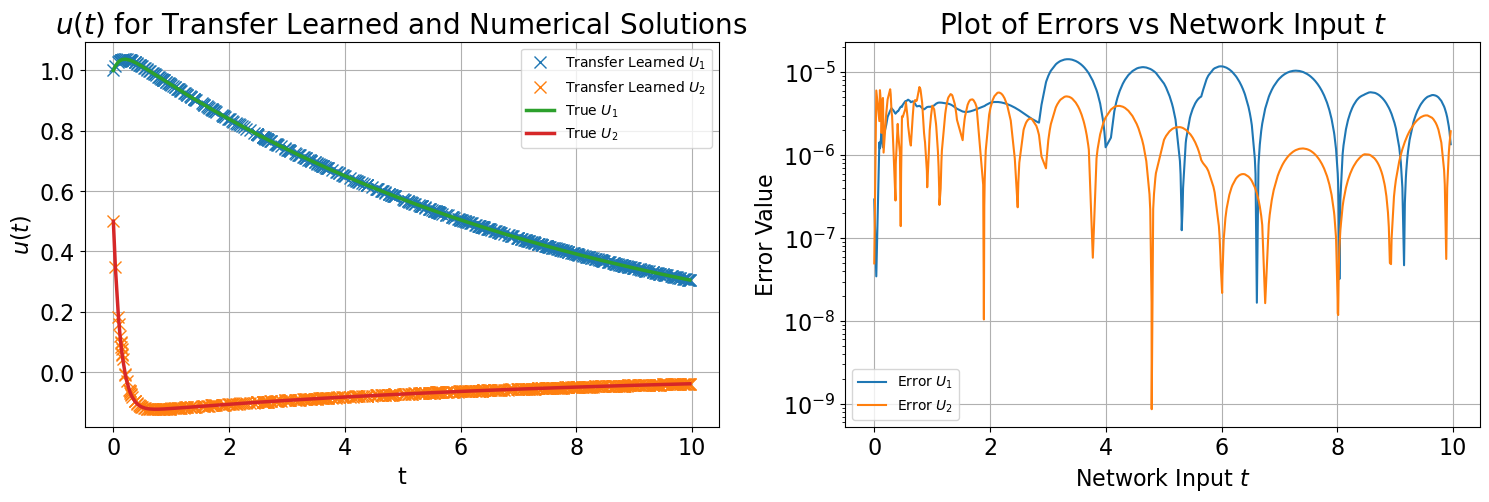

In [37]:
# forward pass to extract H
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)

# choose an initial condition and set of coefficients that were trained on
v = v_list[2]
A = A_list[2]
force = force_list[2]
M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     v, A, force)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force,
                                     num_equations, numerical_sol_fct_radau)

Time to compute weights (given H and dH_dt):  0.120 seconds
mean 0.002292409879161323
max 0.005840657705696306
mean 0.0002257349992078869
max 0.011977039197981737


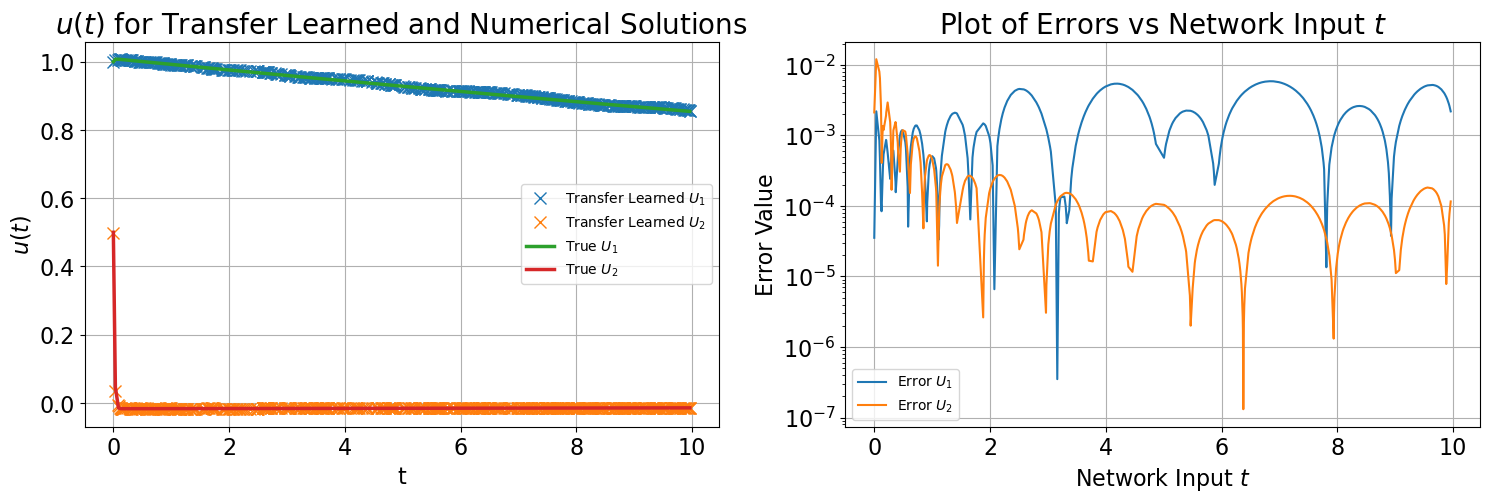

In [38]:
# stiff parameter alpha list
alpha_transfer = 30

transfer_A = get_A(alpha_transfer)
force_transfer = force
IC_transfer = v_list[0]

# compute the transfer learned solution
M_inv_new, W_out_new_A, force_terms_new, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       IC_transfer, transfer_A, force_transfer)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, IC_transfer, transfer_A, force_transfer,
                                     num_equations, numerical_sol_fct_radau)

## Comparative analysis 

- Solve iteratively for several alpha value
- Solve with:
    - PINNS trasnfer learning (only A change)
    - RK45
    - Radeau
    - LSODA
- Get:
    - PINSS: Error + Time to compute
    - RK45: Error + Time to compute
    - Radau: Error + Time to compute
    - LSODA: Error + Time to compute

In [40]:
import time
from collections import defaultdict
from tqdm import tqdm


#alpha_list_transfer = [2, 4, 8, 12, 20, 25, 30, 40, 50, 75, 100, 150, 200]
log_scale = False
alpha_list_transfer = [i for i in range(2, 41, 2)]

computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)

solution = defaultdict(list)

length = t_eval.shape[0]

for alpha in tqdm(alpha_list_transfer):

    transfer_A = get_A(alpha)
    force_transfer = force_list[0]

    # solve with PINNS
    M_inv_new, W_out_new_A, force_terms_new, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       v, transfer_A, force_transfer, verbose=False)
    pinns_sol = torch.matmul(H.double(), W_out_new_A.double())
    solution["PINNS"].append(np.swapaxes(pinns_sol.detach().cpu().numpy().squeeze(), 0, 1))
    computational_time["PINNS"].append(total_time)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy(), v.detach().cpu(),
                            transfer_A.cpu(),
                            force_transfer.detach().cpu())
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

    # true solution
    true_solution = true_solution_Dho(alpha, v[0].item(), v[1].item(), t_eval.detach().cpu().numpy())
    solution["True"].append(true_solution)

    # get error
    max_error["PINNS"].append([]); 
    mean_error["PINNS"].append([]); 
    for method in numerical_methods.keys():
        max_error[method].append([])
        mean_error[method].append([])
    for i in range(num_equations):
      # pinns error
      predicted_vals = pinns_sol[:, i, :].detach().cpu().numpy().squeeze()
      pinns_erros = np.abs(predicted_vals - true_solution[i, :])
      max_error["PINNS"][-1].append(pinns_erros.max())
      mean_error["PINNS"][-1].append(pinns_erros.mean())
      # Numerical error
      for method in numerical_methods.keys():
        sol = solution[method]
        numerical_error = np.abs(sol[-1][i] - true_solution[i])
        max_error[method][-1].append(numerical_error.max())
        mean_error[method][-1].append(numerical_error.mean())

100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


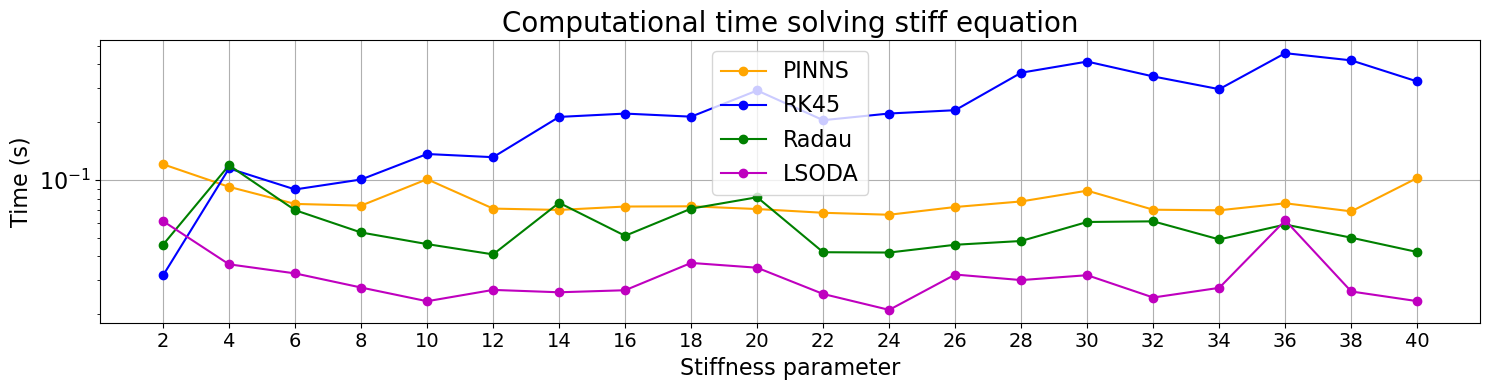

In [41]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(15, 4))

for method, time in computational_time.items():
    ax.plot(alpha_list_transfer, time, "-o", color=color[method], label=f"{method}")

ax.set_yscale("log")
if log_scale: ax.set_xscale("log")
ax.set_title("Computational time solving stiff equation", fontsize=20)
ax.set_xlabel('Stiffness parameter', fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xticks(alpha_list_transfer, [str(i) for i in alpha_list_transfer])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=16)
ax.grid()

Text(0.5, 0.98, 'Mean Absolute Error solving Stiff Equation')

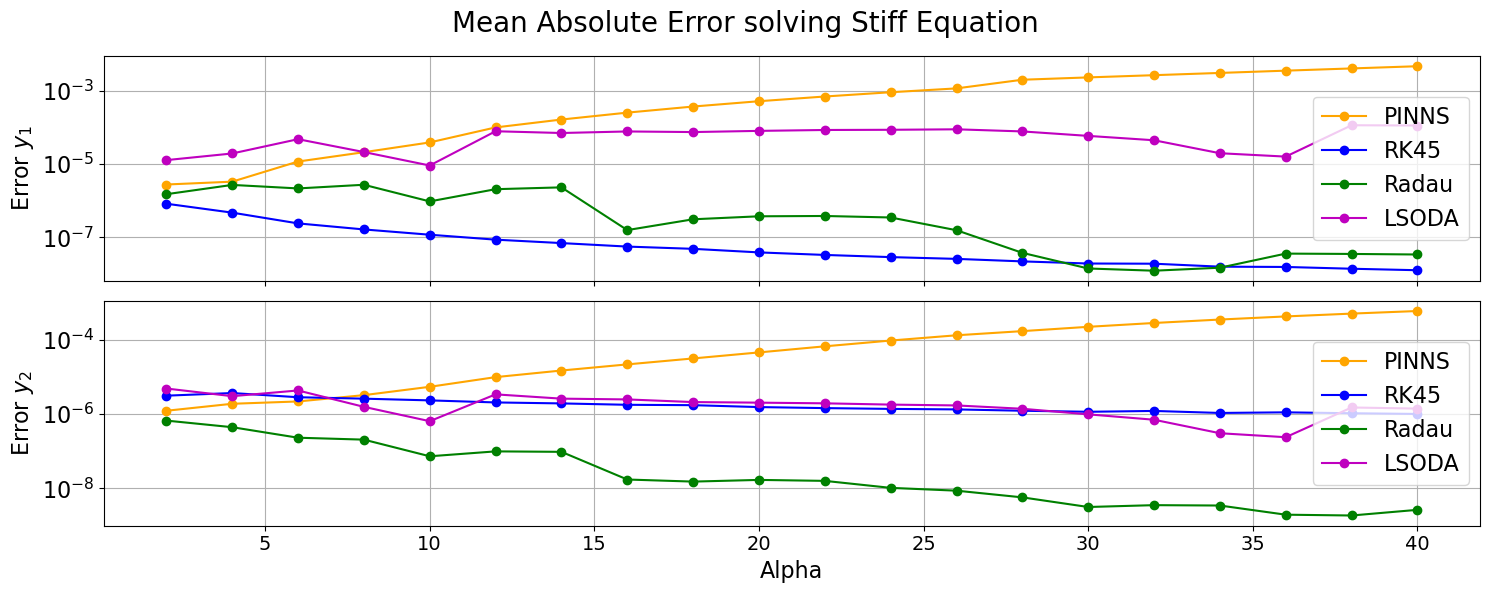

In [42]:
fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)
for method, mean in mean_error.items():
    ax[0].plot(alpha_list_transfer, np.array(mean)[:, 0], '-o', color=color[method], label=f"{method}")
    ax[1].plot(alpha_list_transfer, np.array(mean)[:, 1], '-o', color=color[method], label=f"{method}")

ax[0].set_yscale("log")
if log_scale: ax[0].set_xscale("log")
ax[0].set_ylabel('Error $y_1$', fontsize=16)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=16)
ax[0].legend(loc='best', fontsize=16)
ax[0].grid()

ax[1].set_yscale("log")
if log_scale: ax[1].set_xscale("log")
ax[1].set_xlabel('Alpha', fontsize=16)
ax[1].set_ylabel('Error $y_2$', fontsize=16)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=16)
ax[1].legend(loc='best', fontsize=16)
ax[1].grid()

fig.suptitle("Mean Absolute Error solving Stiff Equation", fontsize=20)

Text(0.5, 0.98, 'Max Absolute Error solving Stiff Equation')

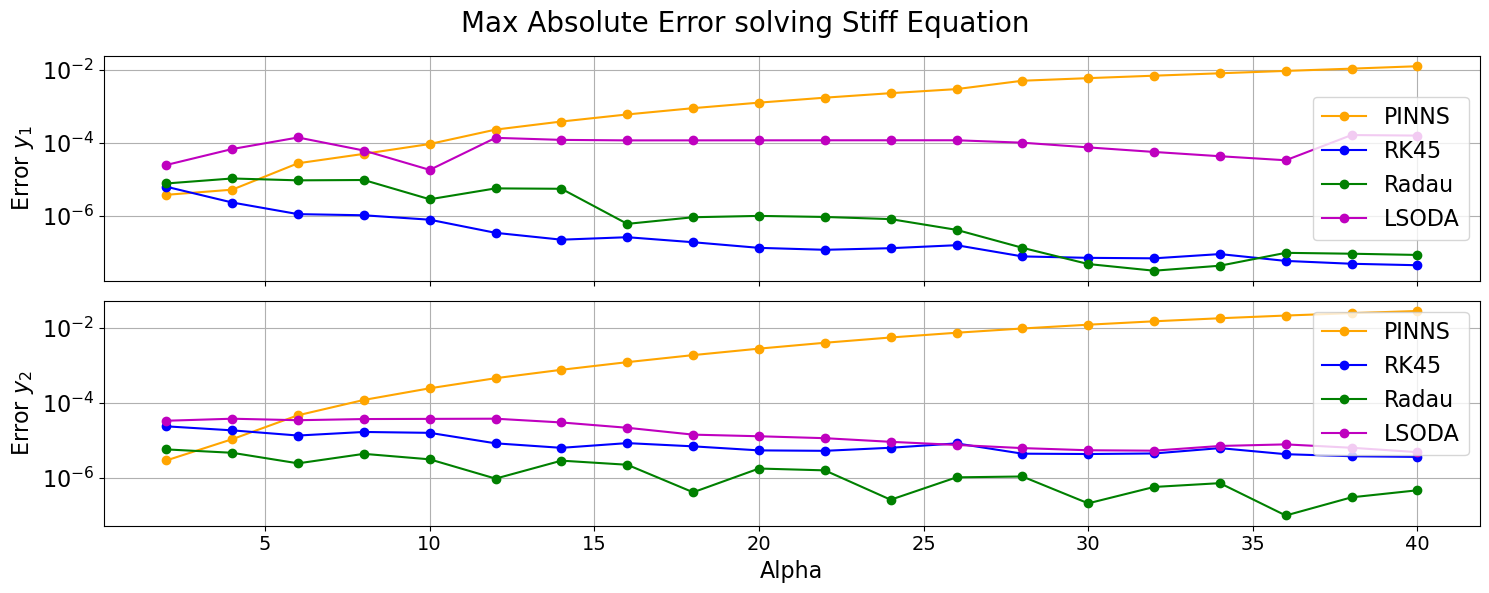

In [43]:
fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)
for method, max in max_error.items():
    ax[0].plot(alpha_list_transfer, np.array(max)[:, 0], '-o', color=color[method], label=f"{method}")
    ax[1].plot(alpha_list_transfer, np.array(max)[:, 1], '-o', color=color[method], label=f"{method}")

ax[0].set_yscale("log")
if log_scale: ax[0].set_xscale("log")
ax[0].set_ylabel('Error $y_1$', fontsize=16)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=16)
ax[0].legend(loc='best', fontsize=16)
ax[0].grid()

ax[1].set_yscale("log")
if log_scale: ax[1].set_xscale("log")
ax[1].set_xlabel('Alpha', fontsize=16)
ax[1].set_ylabel('Error $y_2$', fontsize=16)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=16)
ax[1].legend(loc='best', fontsize=16)
ax[1].grid()

fig.suptitle("Max Absolute Error solving Stiff Equation", fontsize=20)

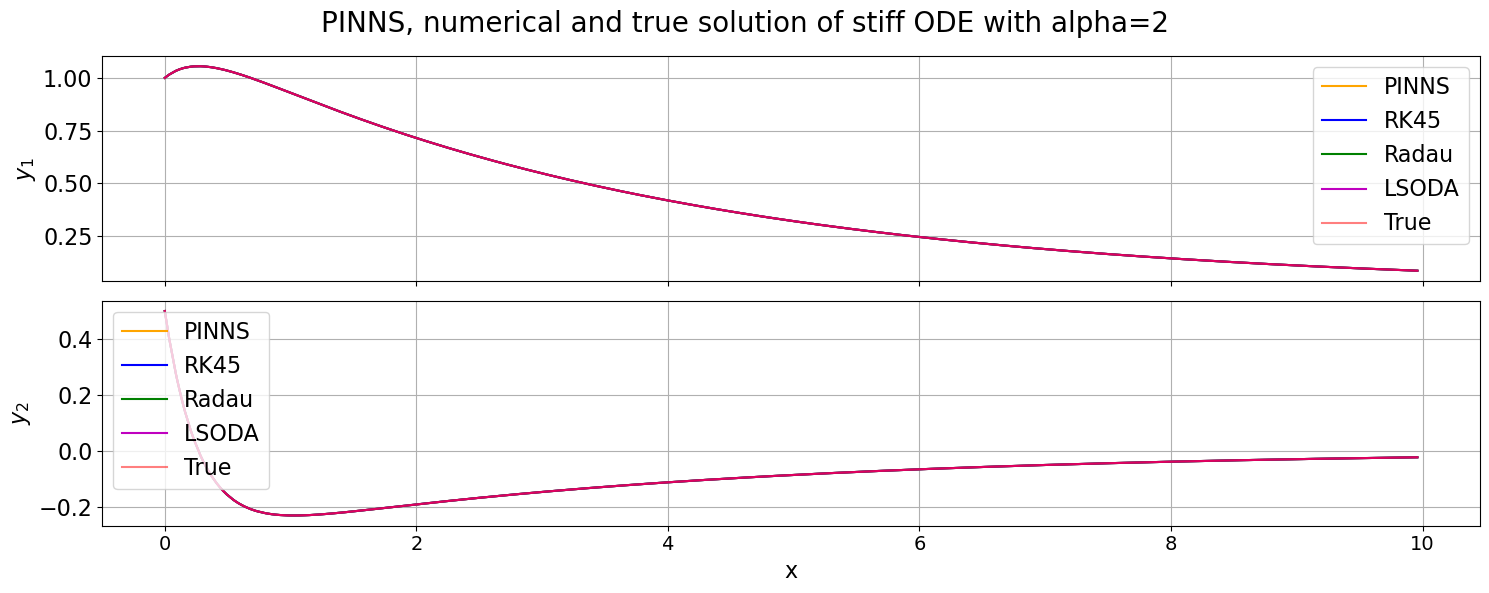

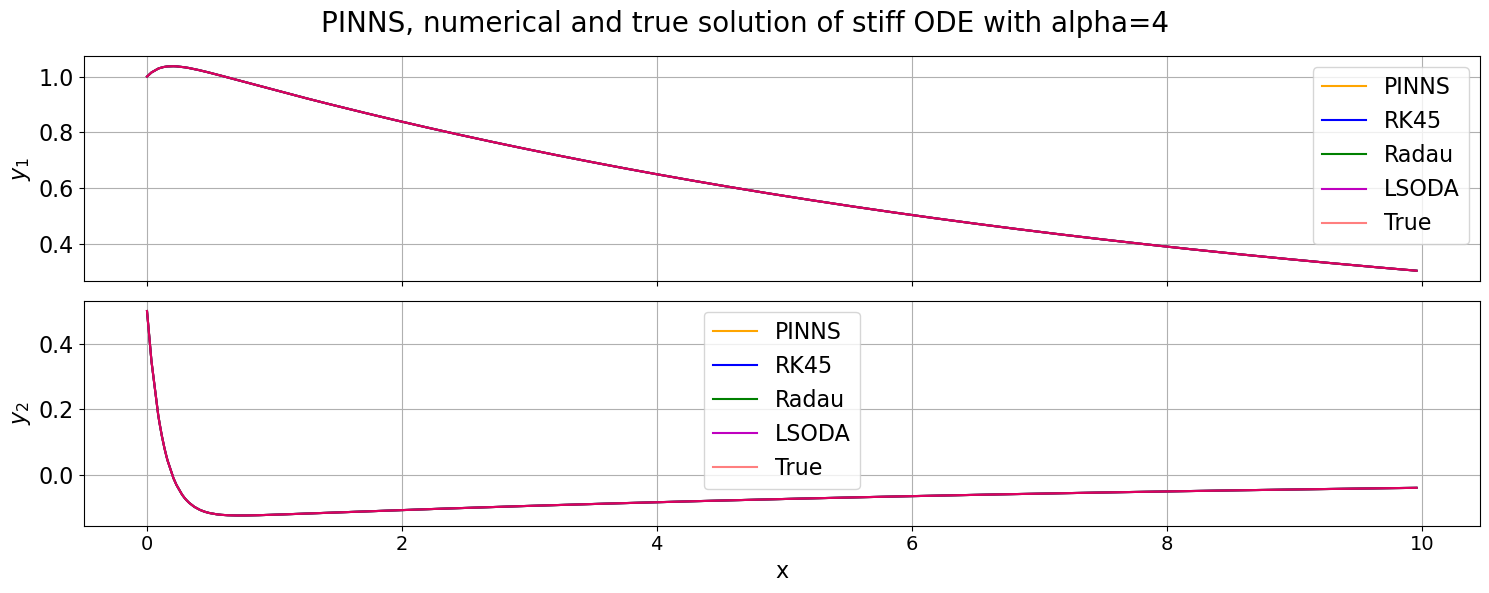

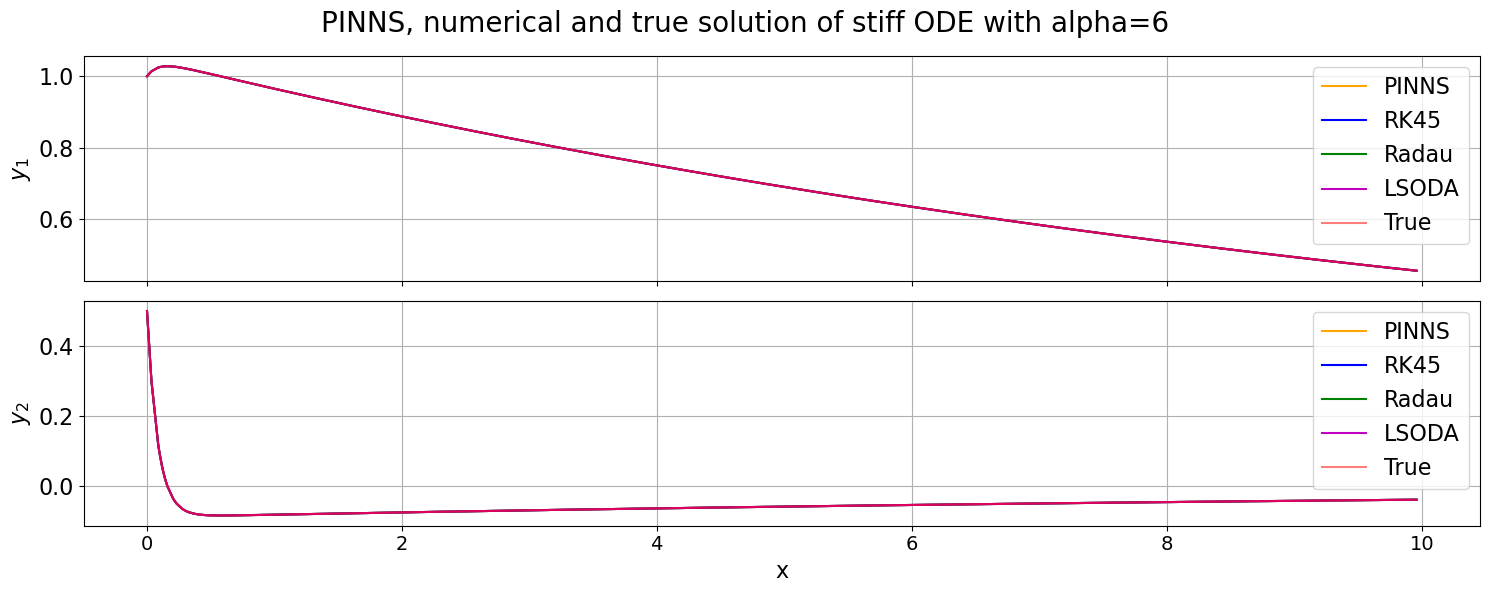

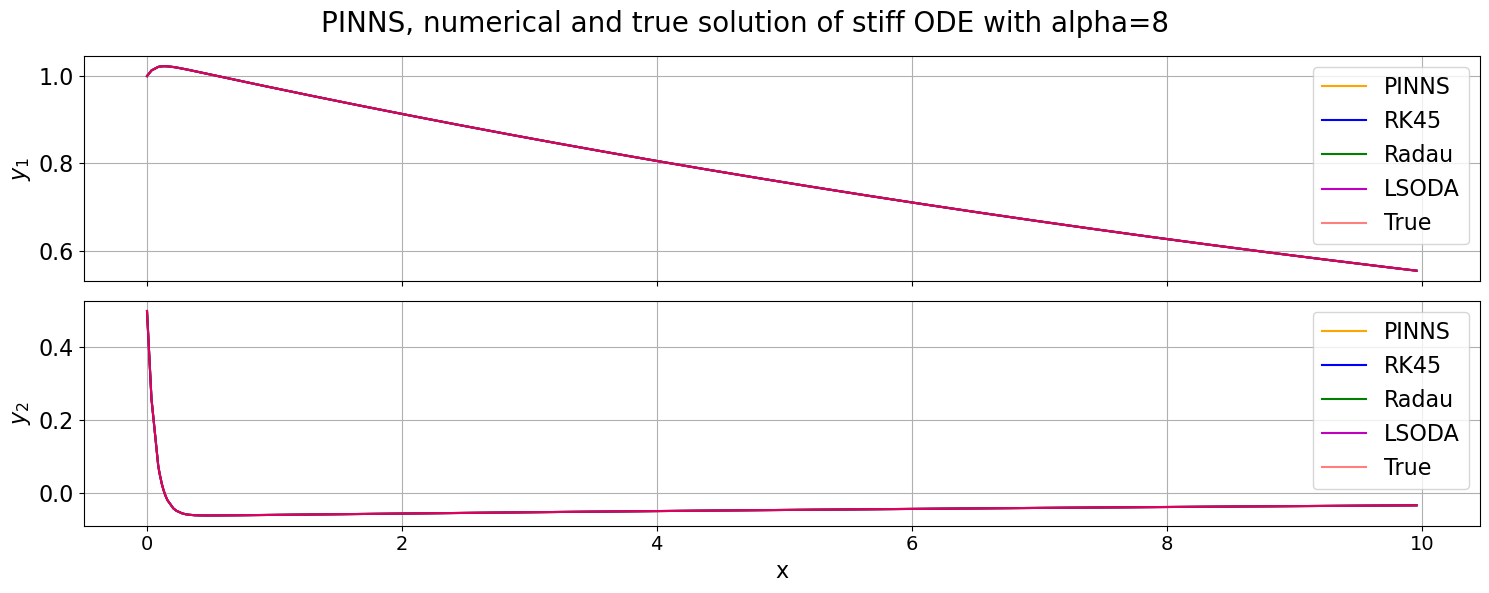

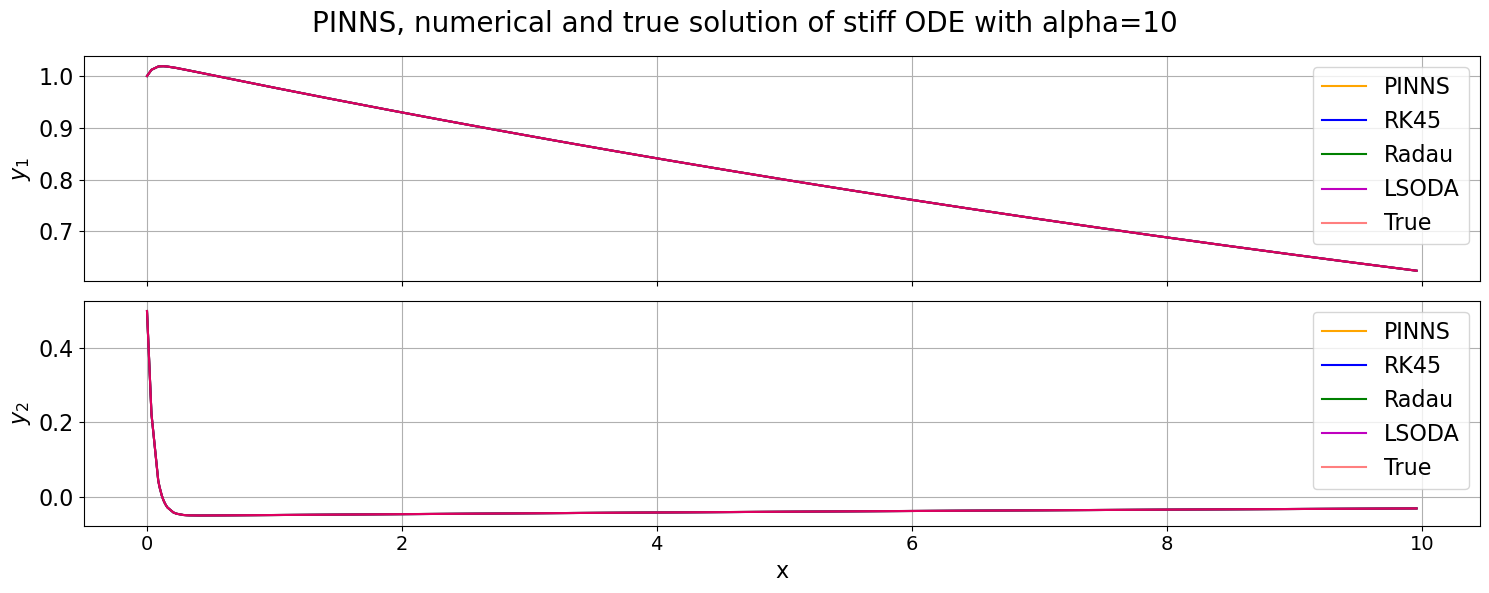

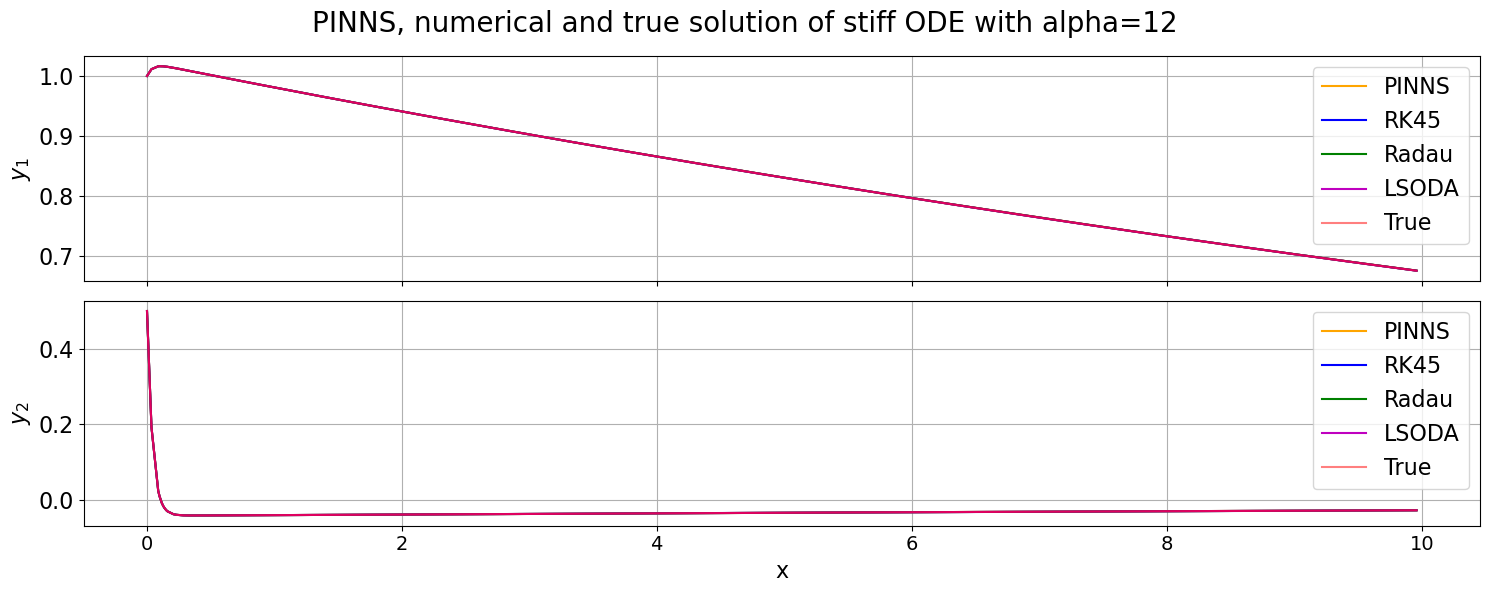

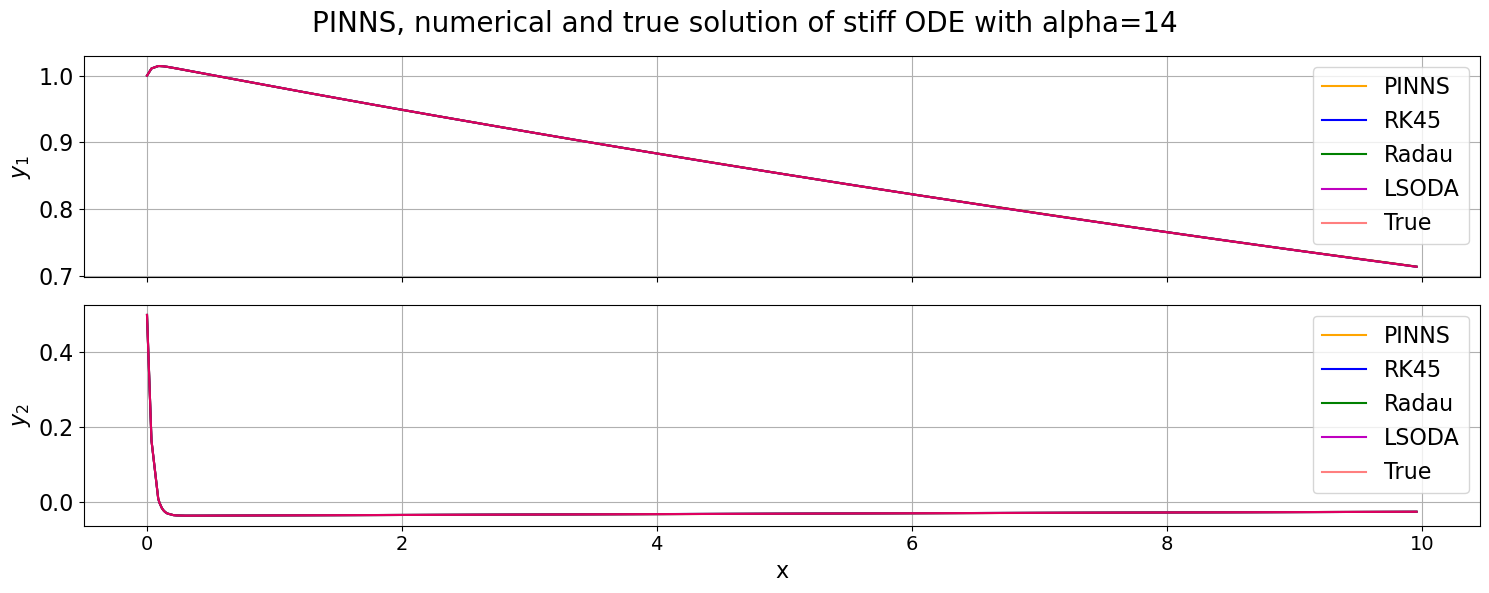

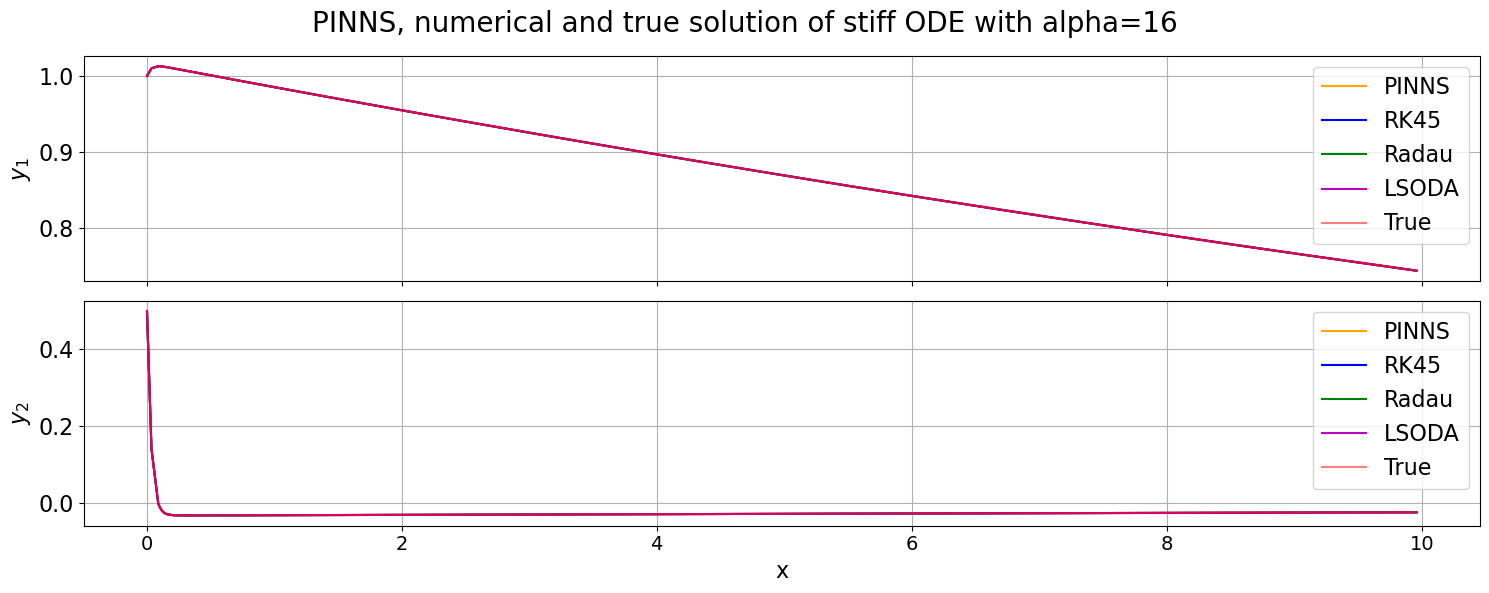

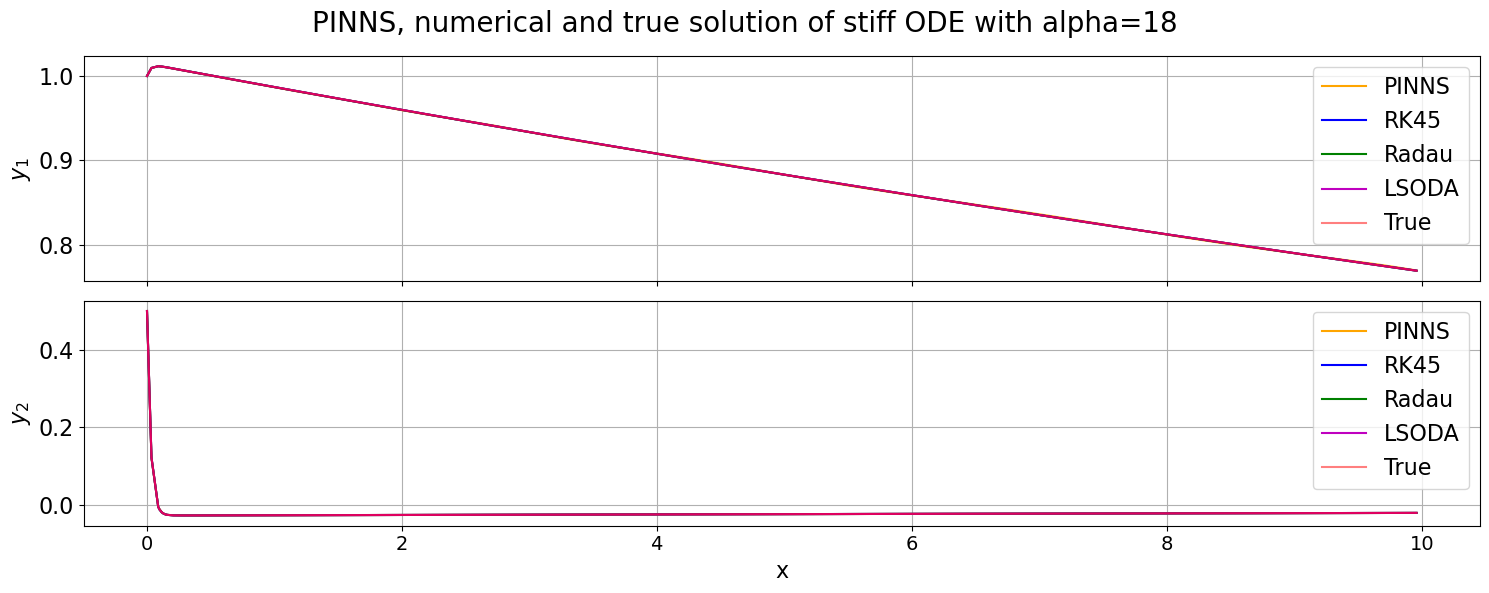

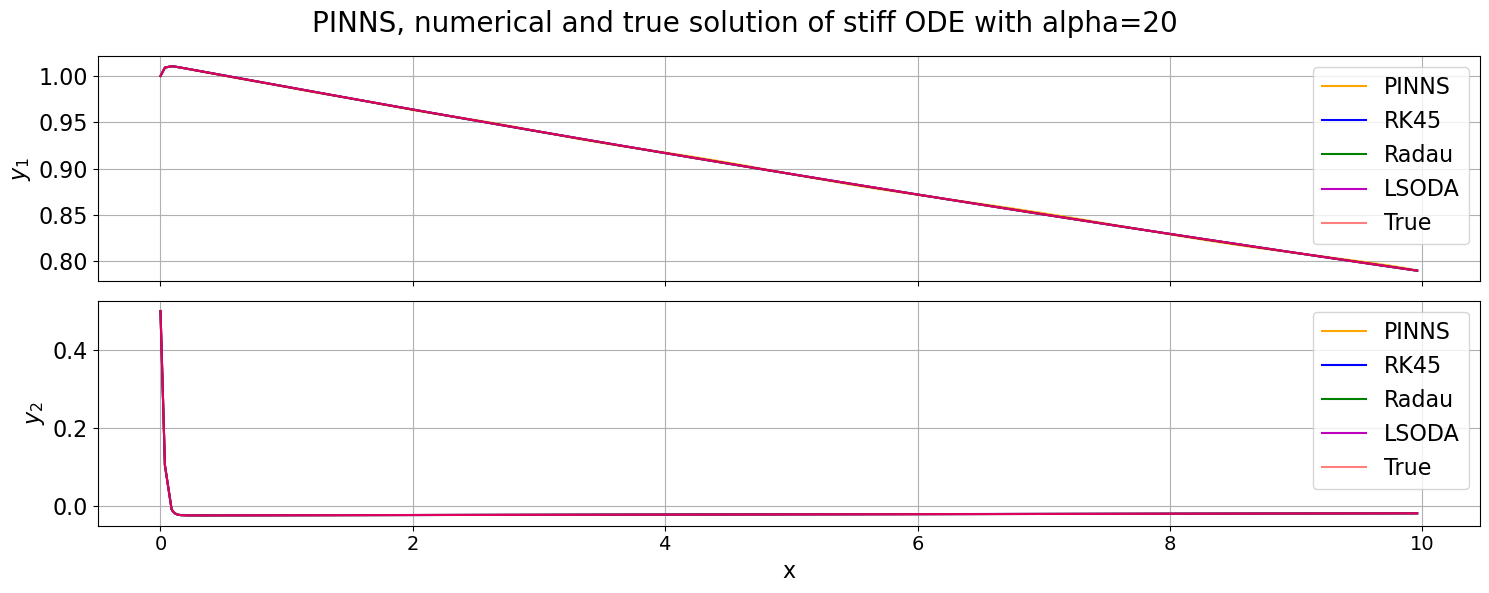

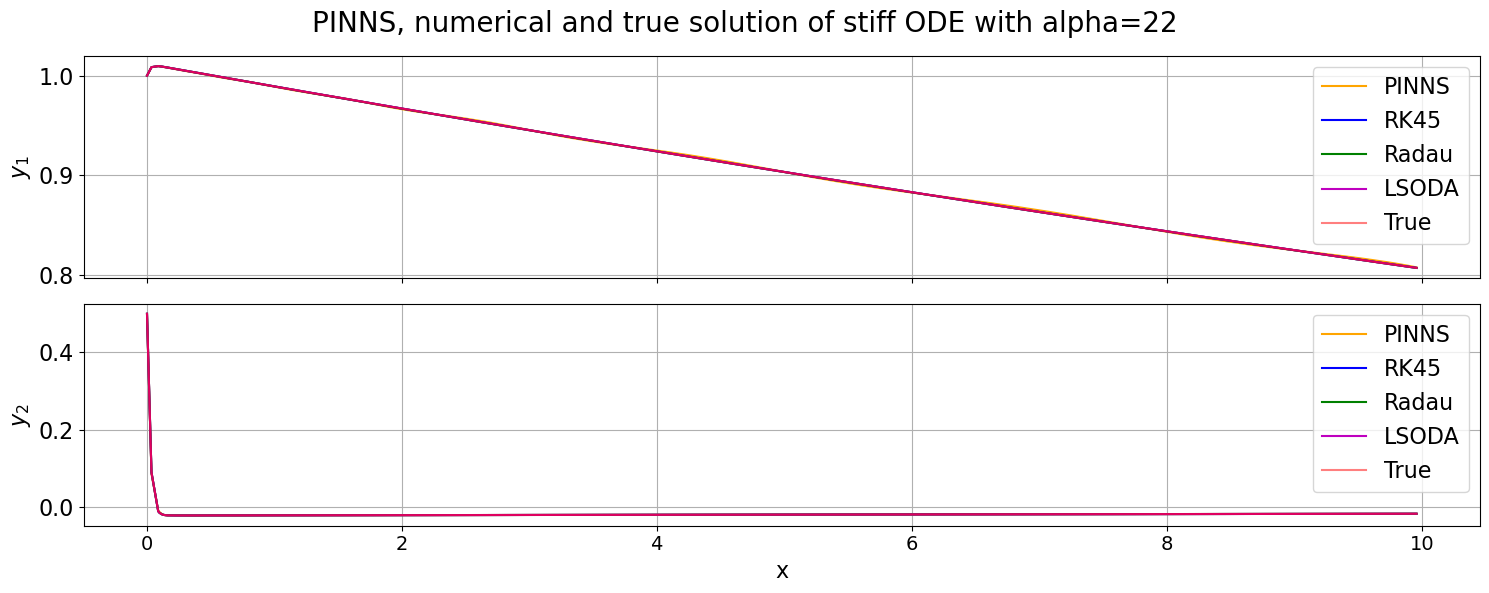

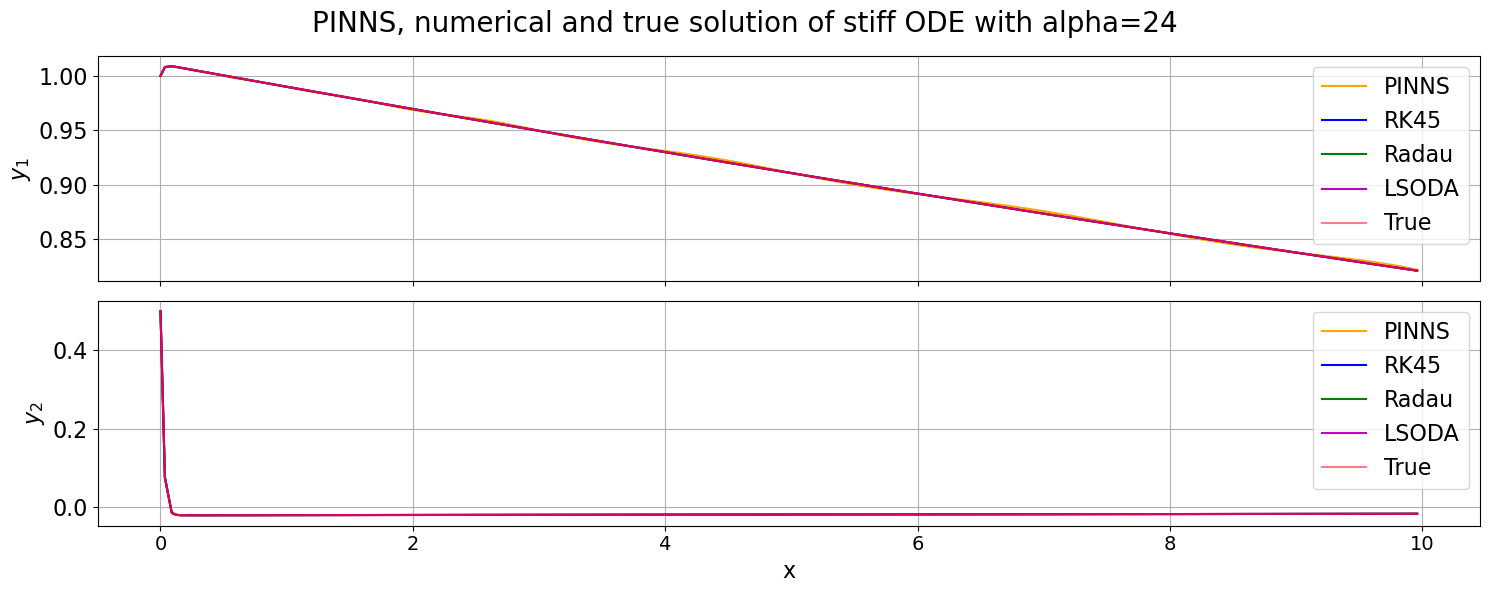

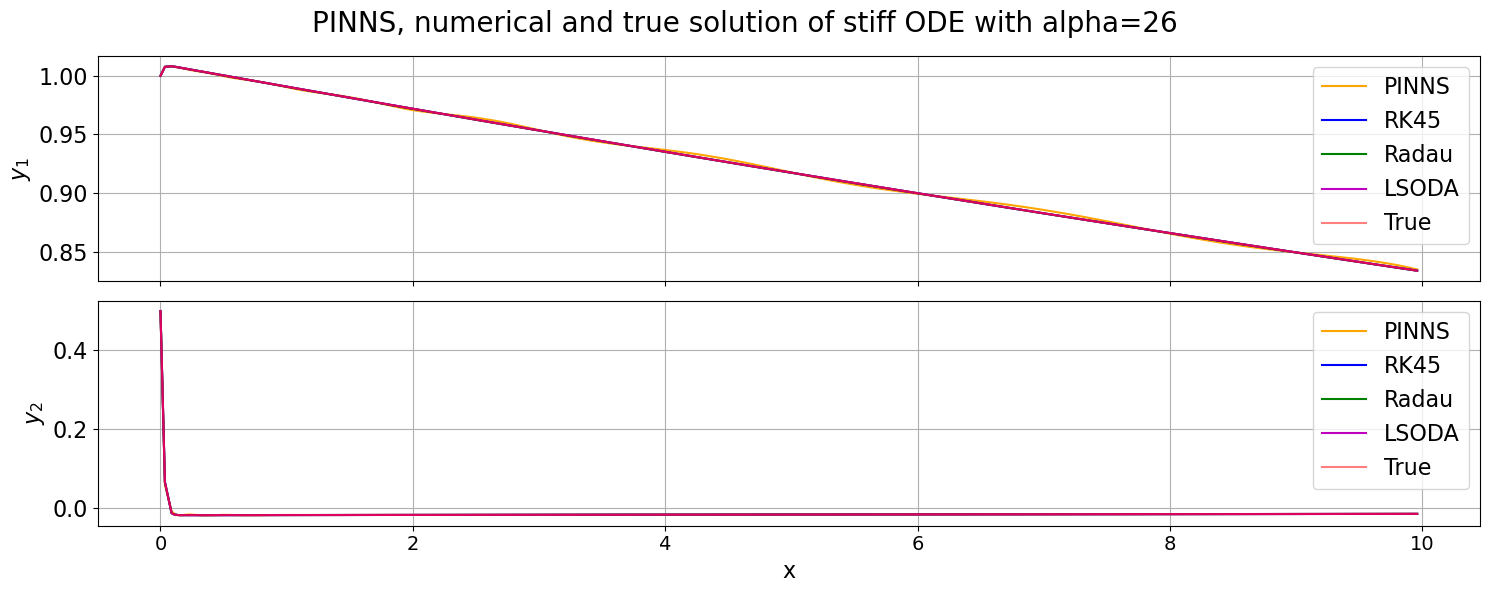

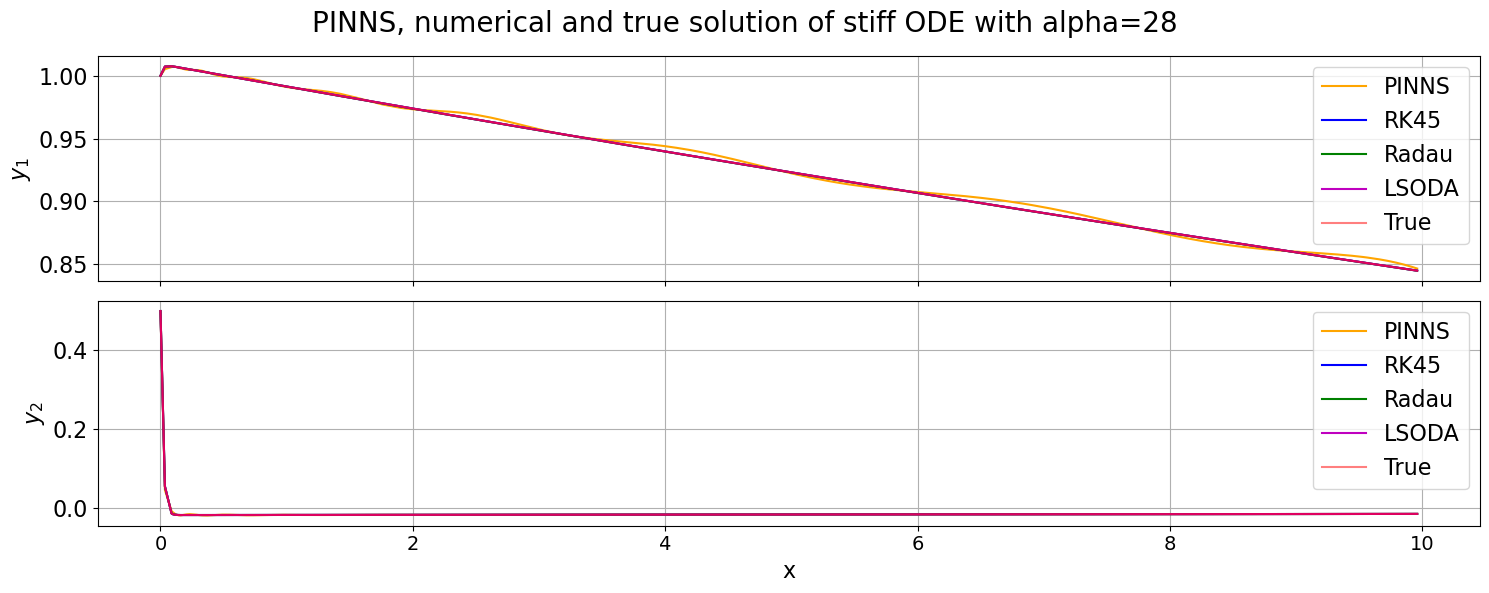

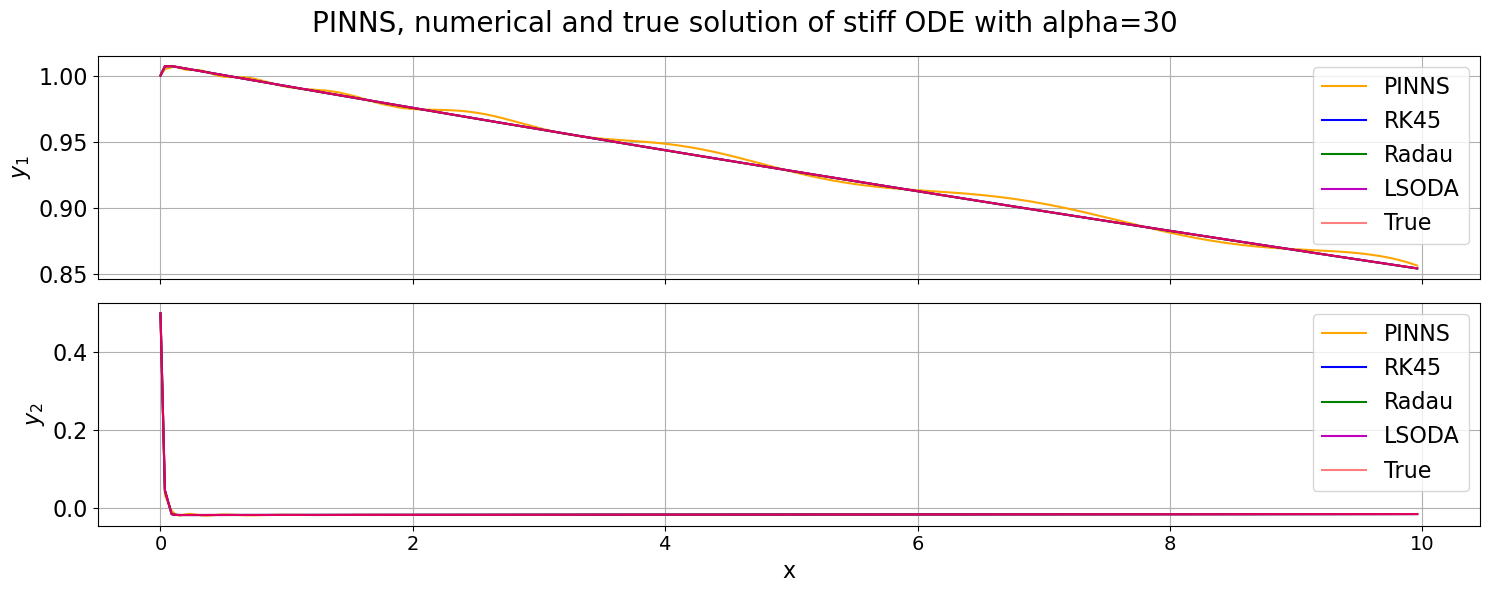

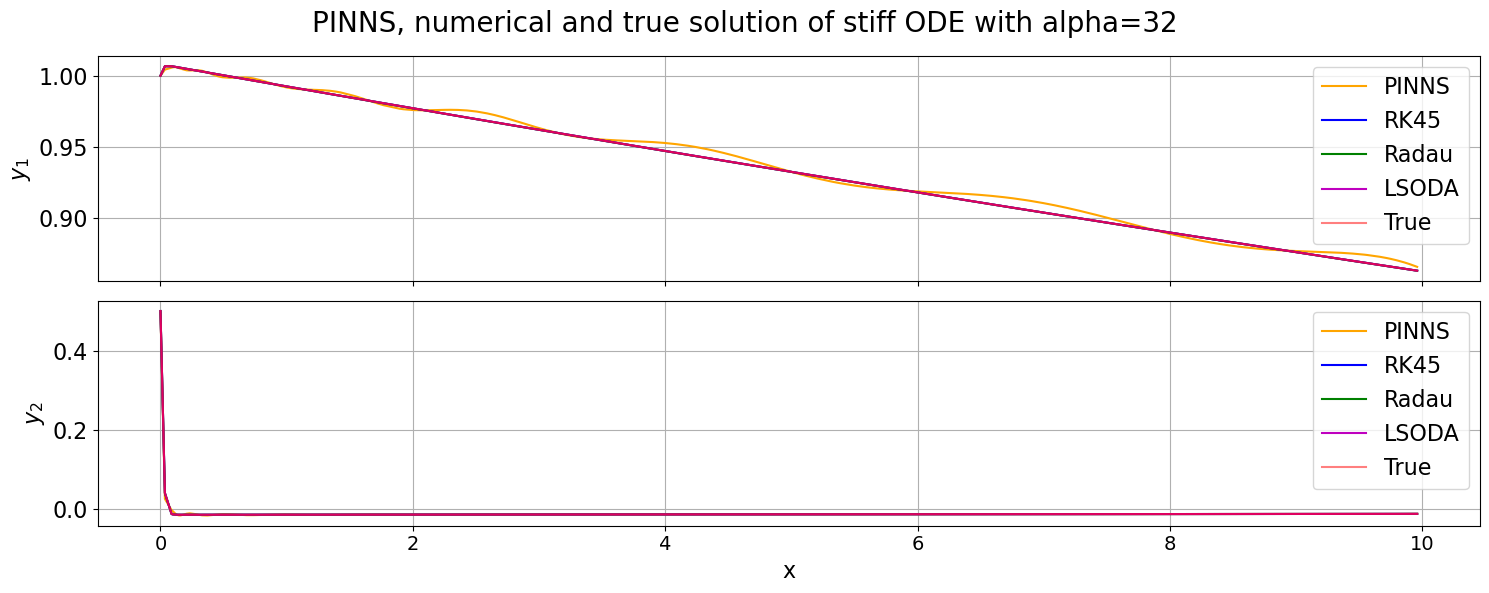

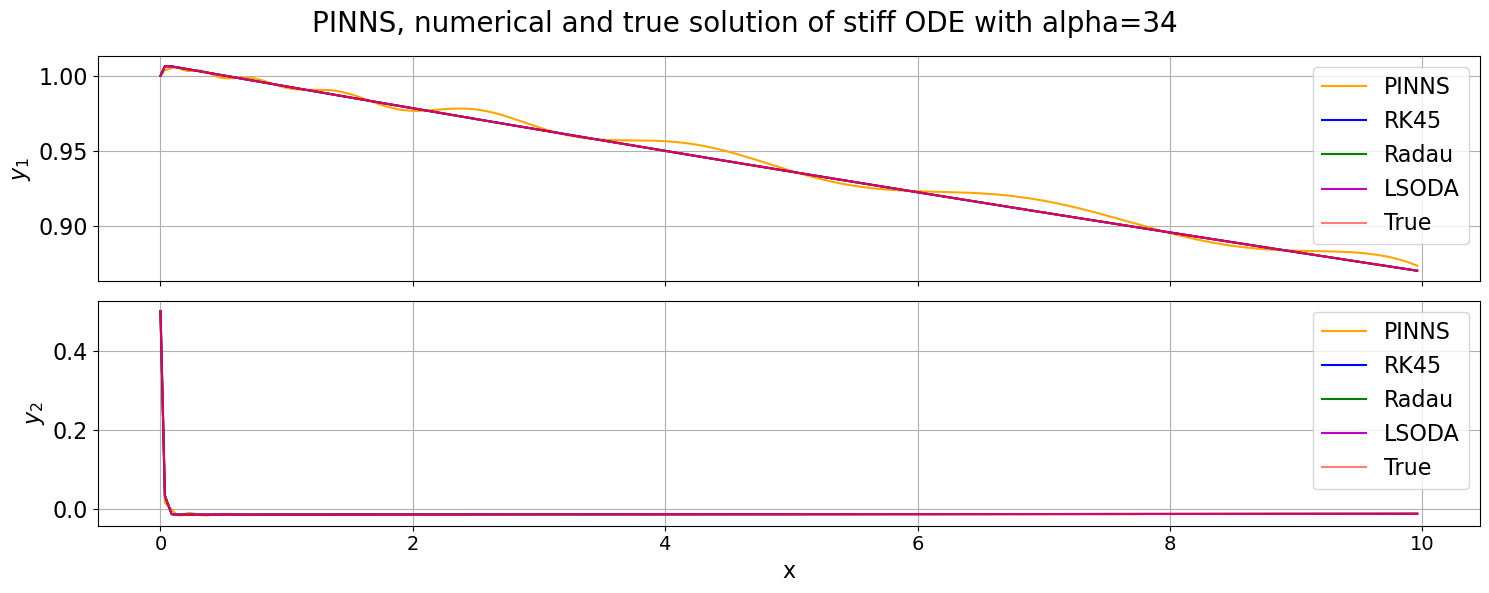

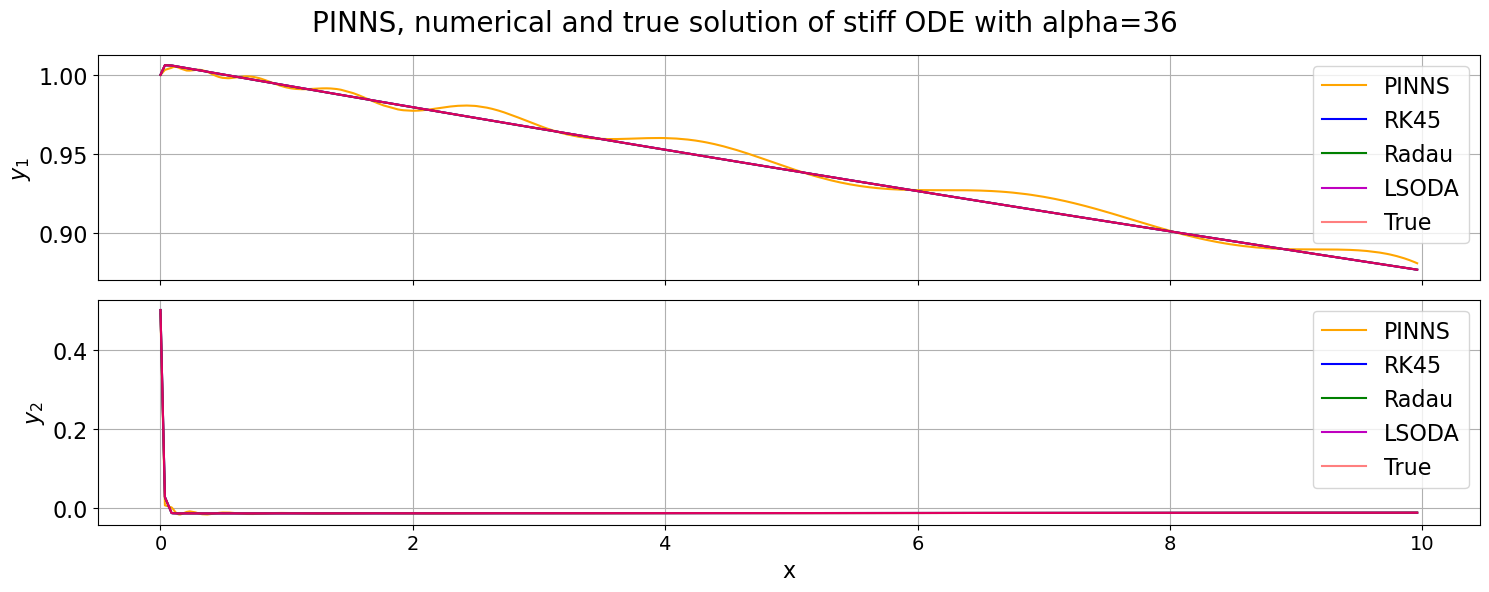

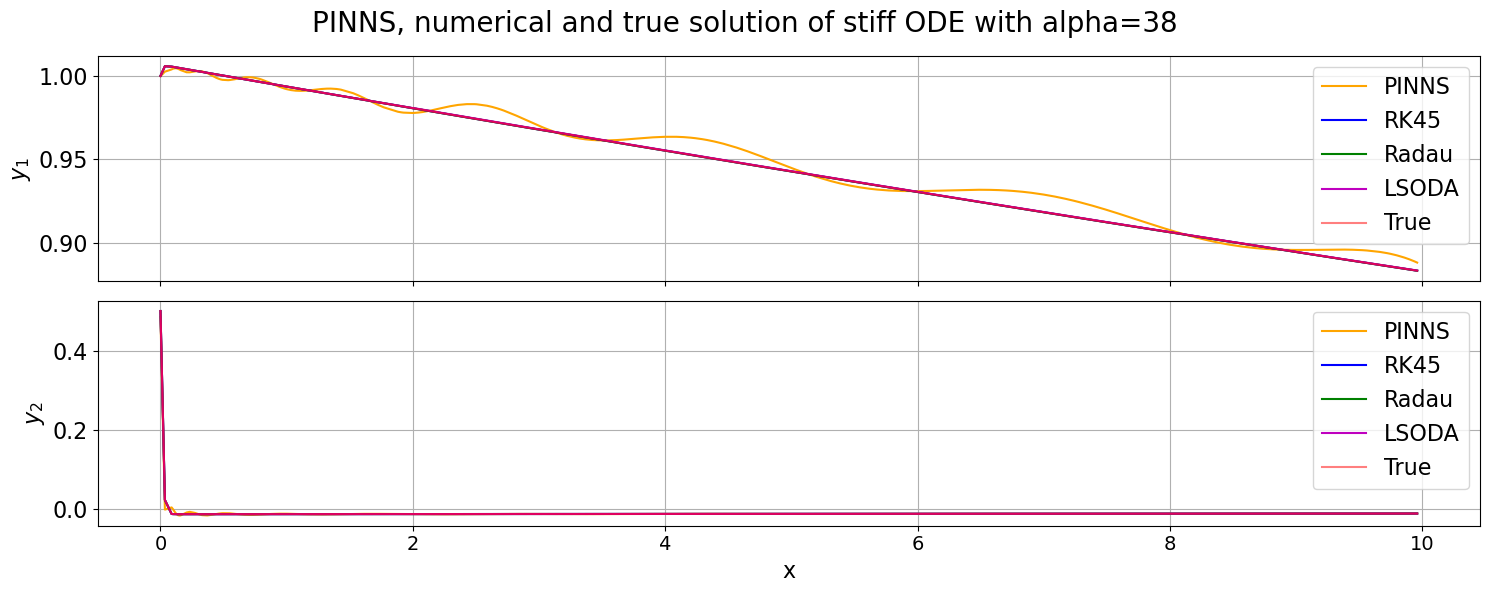

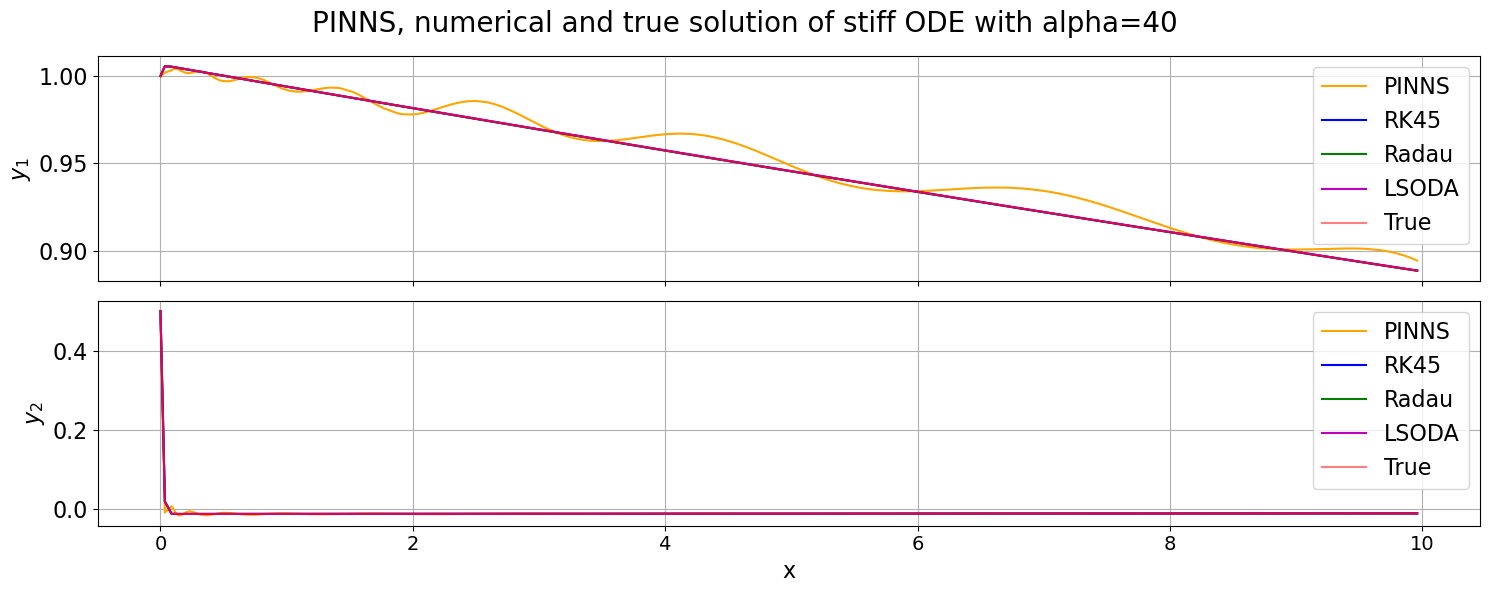

In [44]:
for i in range(len(alpha_list_transfer)):
    fig, ax = plt.subplots(2, tight_layout=True, figsize=(15, 6), sharex=True)
    for method, value in solution.items():
        ax[0].plot(t_eval.detach().cpu().squeeze(), value[i][0, :].squeeze(), color=color[method], label=f"{method}")
        ax[1].plot(t_eval.detach().cpu().squeeze(), value[i][1, :].squeeze(), color=color[method], label=f"{method}")

    ax[0].set_ylabel('$y_1$', fontsize=16)
    ax[0].tick_params(axis='x', labelsize=14)
    ax[0].tick_params(axis='y', labelsize=16)
    ax[0].legend(loc='best', fontsize=16)
    #ax[0].set_ylim([0, 1.2])
    ax[0].grid()

    ax[1].set_xlabel('x', fontsize=16)
    ax[1].set_ylabel('$y_2$', fontsize=16)
    ax[1].tick_params(axis='x', labelsize=14)
    ax[1].tick_params(axis='y', labelsize=16)
    ax[1].legend(loc='best', fontsize=16)
    ax[1].grid()

    fig.suptitle(f"PINNS, numerical and true solution of stiff ODE with alpha={alpha_list_transfer[i]}", fontsize=20)